### Process the locations

In [12]:
## just to process the locations
locations = read_csv('../locations.csv', header=None)
locations.head()

,0,1,2,3,4
0,../../../data/train/b2dd7c30d,[327.27408 410.49097 832.38605 616.7272 ],[-0.87499994 -0.87499994 -0.87499994 -0.87499994],[-0.87499994 -0.87499994 -0.87499994 -0.87499994],[-0.87499994 -0.87499994 -0.87499994 -0.87499994]
1,../../../data/train/8223ae8a6,[ 0. 0. 1020.5525 593.13574],[-0.7876969 -0.7876969 -0.7876969 -0.7876969],[-0.7876969 -0.7876969 -0.7876969 -0.7876969],[-0.7876969 -0.7876969 -0.7876969 -0.7876969]
2,../../../data/train/9c4f89399,[ 90.74706 80.06205 962.94354 484.37234],[-0.87499994 -0.87499994 -0.87499994 -0.87499994],[-0.87499994 -0.87499994 -0.87499994 -0.87499994],[-0.87499994 -0.87499994 -0.87499994 -0.87499994]
3,../../../data/train/24d8db3a0,[ 13.511846 81.32377 1033.6593 373.78296 ],[-0.7876969 -0.7876969 -0.7876969 -0.7876969],[-0.7876969 -0.7876969 -0.7876969 -0.7876969],[-0.7876969 -0.7876969 -0.7876969 -0.7876969]
4,../../../data/train/159eb7cc8,[ 9.834552 96.21421 700. 331.09885 ],[-0.625 -0.625 -0.625 -0.625],[-0.625 -0.625 -0.625 -0.625],[-0.625 -0.625 -0.625 -0.625]


In [15]:
locations.drop([2, 3, 4], axis=1, inplace=True)
locations.head()

,0,1
0,../../../data/train/b2dd7c30d,[327.27408 410.49097 832.38605 616.7272 ]
1,../../../data/train/8223ae8a6,[ 0. 0. 1020.5525 593.13574]
2,../../../data/train/9c4f89399,[ 90.74706 80.06205 962.94354 484.37234]
3,../../../data/train/24d8db3a0,[ 13.511846 81.32377 1033.6593 373.78296 ]
4,../../../data/train/159eb7cc8,[ 9.834552 96.21421 700. 331.09885 ]


In [16]:
import numpy as np
import cv2

def draw_box(image, box, color=(255, 0, 0), thickness=2):
    """ Draws a box on an image with a given color.

    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)

[199.17642 192.31587 904.70734 473.7943 ]


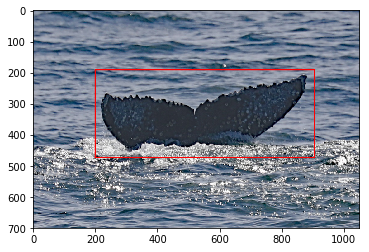

In [60]:
from keras_preprocessing import image
import matplotlib.pyplot as plt

img = pil_image.open('../data/train/' + locations.iloc[2100][0].split('/')[-1] + '.jpg').convert('RGB')
img_array = np.asarray(img)
# img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

box = locations.iloc[2100][1]
# print(box)
box = box.split('[')[1].split(']')[0].split()
# print(box)
box = [int(float(b)) for b in box]
# print(box)
draw_box(img_array, box)
plt.imshow(img_array)

In [61]:
## read locations from locations.csv
p2bb = {}
for i in range(len(locations)):
    p, box = locations.iloc[i]
    p = p.split('/')[-1] + '.jpg'
    box = box.split('[')[1].split(']')[0].split()
    box = [int(float(b)) for b in box]
    p2bb[p] = box

In [64]:
import pickle
with open('../data/bounding-box.pickle', 'wb') as f:
    pickle.dump(p2bb, f)

### Duplicate image identification

In [5]:
# Read the dataset description
import pandas as pd
from pandas import read_csv

tagged = dict([(p, w) for _, p, w in read_csv('../data/train.csv').to_records()])
submit = [p for _, p, _ in read_csv('../sample_submission.csv').to_records()]
join = list(tagged.keys()) + submit
len(tagged), len(submit), len(join), list(tagged.items())[:5], submit[:5]


(25361,
 7960,
 33321,
 [('0000e88ab.jpg', 'w_f48451c'),
  ('0001f9222.jpg', 'w_c3d896a'),
  ('00029d126.jpg', 'w_20df2c5'),
  ('00050a15a.jpg', 'new_whale'),
  ('0005c1ef8.jpg', 'new_whale')],
 ['00028a005.jpg',
  '000dcf7d8.jpg',
  '000e7c7df.jpg',
  '0019c34f4.jpg',
  '001a4d292.jpg'])

In [10]:
# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('../data/train/' + p):
        return '../data/train/' + p
    if isfile('../data/test/' + p):
        return '../data/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

HBox(children=(IntProgress(value=0, max=33321), HTML(value='')))

(33321,
 [('0000e88ab.jpg', (1050, 700)),
  ('0001f9222.jpg', (758, 325)),
  ('00029d126.jpg', (1050, 497)),
  ('00050a15a.jpg', (1050, 525)),
  ('0005c1ef8.jpg', (1050, 525))])

In [69]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

def match(h1, h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 = pil_image.open(expand_path(p1))
            i2 = pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size:
                return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1 / sqrt((a1 ** 2).mean())
        
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2 / sqrt((a2 ** 2).mean())
        
            a = ((a1 - a2) ** 2).mean()
            if a > 0.1: return False
        
    return True

In [71]:
# Compute phash for each image in the training and test set.
p2h = {}
for p in tqdm_notebook(join):
    img = pil_image.open(expand_path(p))
    h = phash(img)
    p2h[p] = h

# find all images associated with a given phash value.
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps: 
        h2ps[h] = []
    if p not in h2ps[h]:
        h2ps[h].append(p)

# find all distict phash values
hs = list(h2ps.keys())

# If the images are close enough, associate the two phash values
h2h = {}
for i, h1 in enumerate(tqdm_notebook(hs)):
    for h2 in hs[:i]:
        if h1 - h2 <= 6 and match(h1, h2):
            s1 = str(h1)
            s2 = str(h2)
            if s1 < s2:
                s1, s2 = s2, s1
            h2h[s1] = s2

# Group together images with equivalent phash, and replace by string format of phash
for p, h in p2h.items():
    h = str(h)
    if h in h2h:
        h = h2h[h]
    p2h[p] = h
    
len(p2h), list(p2h.items())[:5]

HBox(children=(IntProgress(value=0, max=33317), HTML(value='')))

(33321,
 [('0000e88ab.jpg', 'd26698c3271c757c'),
  ('0001f9222.jpg', 'ba8cc231ad489b77'),
  ('00029d126.jpg', 'bbcad234a52d0f0b'),
  ('00050a15a.jpg', 'c09ae7dc09f33a29'),
  ('0005c1ef8.jpg', 'd02f65ba9f74a08a')])

In [94]:
# For each image id, determine the list of pictures
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps:
        h2ps[h] = []
    if p not in h2ps[h]:
        h2ps[h].append(p)

len(h2ps), list(h2ps.items())[:5]

(33317,
 [('d26698c3271c757c', ['0000e88ab.jpg']),
  ('ba8cc231ad489b77', ['0001f9222.jpg']),
  ('bbcad234a52d0f0b', ['00029d126.jpg']),
  ('c09ae7dc09f33a29', ['00050a15a.jpg']),
  ('d02f65ba9f74a08a', ['0005c1ef8.jpg'])])

In [77]:
# Show an example of a duplicate image (from training of test set)
import matplotlib.pyplot as plt
%matplotlib inline

def show_whale(imgs, per_row=2):
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
    for ax in axes.flatten():
        ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())):
        ax.imshow(img.convert('RGB'))

Images: ['01f66ca26.jpg', 'd37179fd1.jpg']


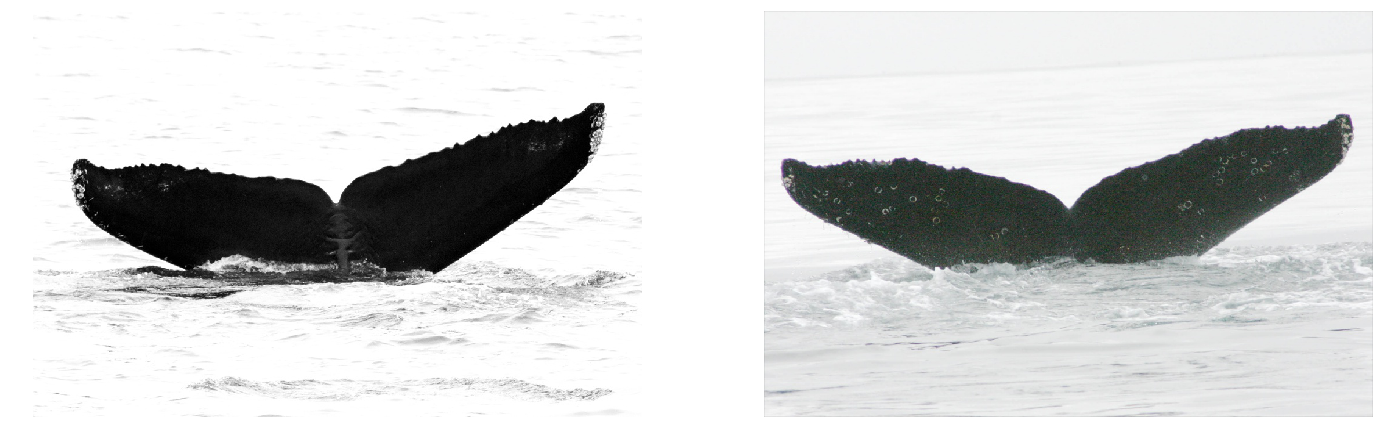

In [79]:
for h, ps in h2ps.items():
    if len(ps) > 1:
        print("Images:", ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

In [97]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1:
        return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0] * s[1] > best_s[0] * best_s[1]:
            best_p = p
            best_s = s
    return best_p

In [98]:
h2p = {}
for h, ps in h2ps.items(): 
    h2p[h] = prefer(ps)
len(h2p), list(h2p.items())[:5]

(33317,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

### Image preprocessing

#### Image rotation

In [100]:
def read_raw_image(p):
    return pil_image.open(expand_path(p))

#### Convert to black and white

In [99]:
with open('../data/bounding-box.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]

[('b2dd7c30d.jpg', [327, 410, 832, 616]),
 ('8223ae8a6.jpg', [0, 0, 1020, 593]),
 ('9c4f89399.jpg', [90, 80, 962, 484]),
 ('24d8db3a0.jpg', [13, 81, 1033, 373]),
 ('159eb7cc8.jpg', [9, 96, 700, 331])]

In [202]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
import keras 
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array, array_to_img
from scipy.ndimage import affine_transform

img_shape = (384, 384, 1) # The image shape used by the model
anisotropy = 2.15  # The horizontal compression ratio
crop_margin = 0.05 # The margin added around the bounding box to compensate for bounding box inaccuracy

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation = np.deg2rad(rotation)
    shear = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], 
                               [-np.sin(rotation), np.cos(rotation), 0],
                               [0, 0, 1]])
    shift_matrix = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix = np.array([[1.0 / height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    if p in h2p:
        p = h2p[p]
    size_x, size_y = p2size[p]
    
    # Determin the region of the original image we want to capture based on the bounding box.
    x0, y0, x1, y1 = p2bb[p]
    w = x1 - x0
    h = y1 - y0
    # 因为我的 RetinaNet predict 出来的 box 已经是偏大了，所以就不再增加 margin了
#     x0 -= w * crop_margin
#     x1 += w * crop_margin + 1
#     y0 -= h * crop_margin
#     y1 += h * crop_margin + 1
    if (x1 < 0):
        x0 = 0
    if (x1 > size_x):
        x1 = size_x
    if (y0 < 0):
        y0 = 0
    if (y1 > size_y):
        y1 = size_y
    w = x1 - x0
    h = y1 - y0
    if w > h * anisotropy:  # 太宽了，把高度增加一下
        h = 0.5 * (w / anisotropy - h)
        y0 -= h
        y1 += h
    else:   # 太高了，把宽度增加一下
        w = 0.5 * (h * anisotropy - w)
        x0 -= w
        x1 += w
    
    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5 * img_shape[0]], [0, 1, -0.5 * img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0) / img_shape[0], 0, 0], 
                             [0, (x1 - x0)/ img_shape[1], 0], 
                             [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
                random.uniform(-5, 5),
                random.uniform(-5, 5),
                random.uniform(0.8, 1.0),
                random.uniform(0.8, 1.0),
                random.uniform(-0.05 * (y1 - y0), 0.05 * (y1 - y0)),
                random.uniform(-0.05 * (x1 - x0), 0.05 * (x1 - x0))), trans)
    trans = np.dot(np.array([[1, 0, 0.5 * (y1 + y0)],
                            [0, 1, 0.5 * (x1 + x0)],
                            [0, 0, 1]]), trans)
    
    # Read the image, transform to black and white and convert to numpy array
    img = read_raw_image(p).convert('L')
    img = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2, :2]
    offset = trans[:2, 2]
    img = img.reshape(img.shape[:-1])
#     print(np.average(img))
    img = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img = img.reshape(img_shape)
    
    # Normalize to zero mean and unit variance
    img -= np.mean(img, keepdims=True)
    img /= np.std(img, keepdims=True) + K.epsilon()
    return img


def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transorm).
    """
    return read_cropped_image(p, True)


def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)   
    

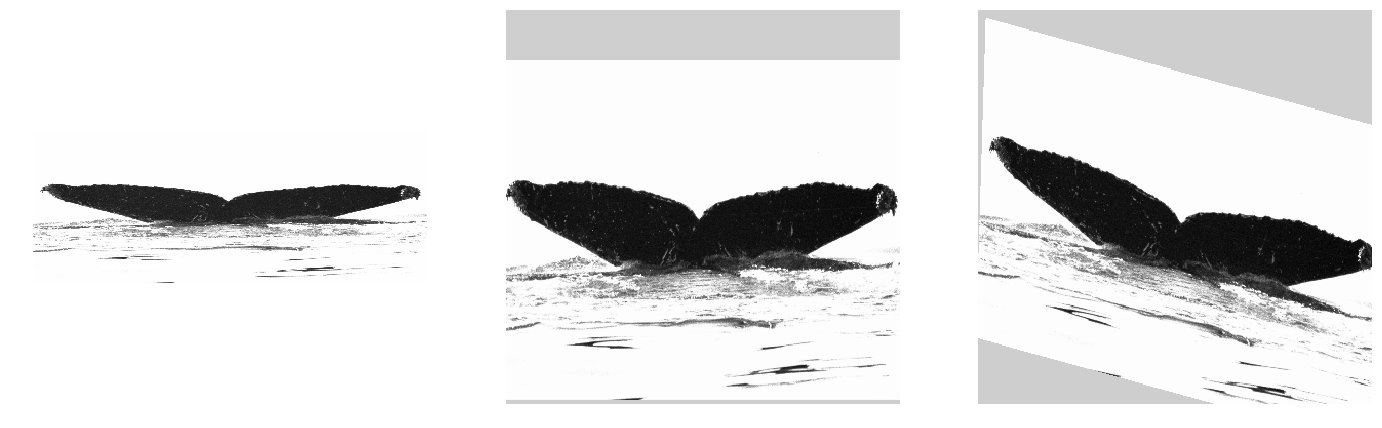

In [203]:
p = list(tagged.keys())[250]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

### Siamese Nerual Network architecture

In [227]:
from keras import regularizers
from keras.optimizers import Adam, sgd
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, \
MaxPooling2D, Flatten, GlobalMaxPooling2D, Lambda, Reshape, Dense
from keras.models import Model

def subblock(x, filters, **kwargs):
    shortcut = BatchNormalization()(x)
    # reduce the dimensions to filters
    x = Conv2D(filters, (1, 1), activation='relu', **kwargs)(x)  
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation='relu', **kwargs)(x)
    x = BatchNormalization()(x)
    # no activation, restore the number of origina features
    x = Conv2D(K.int_shape(shortcut)[-1], (1, 1), **kwargs)(x)
    # Add the bypass connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_model(lr, l2, activation='sigmoid'):
    
    ## Branch model
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}
    
    inp = Input(shape=img_shape)
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)    
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)
    for _ in range(4):
        x = subblock(x, 64, **kwargs)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)
    for _ in range(4):
        x = subblock(x, 64, **kwargs)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)
    for _ in range(4):
        x = subblock(x, 96, **kwargs)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)
    for _ in range(4):
        x = subblock(x, 128, **kwargs)
        
    x = GlobalMaxPooling2D()(x)
    branch_model = Model(inp, x)
    
    # head model
    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:])
    xb_inp = Input(shape=branch_model.output_shape[1:])
    x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x))(x3)
    x = Concatenate()([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)
    
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x = Flatten(name='flatten')(x)
    
    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')
    
    
    ## Siamese neural network
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model    
    
    

In [228]:
model, branch_model, head_model = build_model(64e-5, 0)
head_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 512)           0                                            
____________________________________________________________________________________________________
input_23 (InputLayer)            (None, 512)           0                                            
____________________________________________________________________________________________________
lambda_23 (Lambda)               (None, 512)           0           input_22[0][0]                   
                                                                   input_23[0][0]                   
____________________________________________________________________________________________________
lambda_21 (Lambda)               (None, 512)           0           input_22[0][0]          

In [223]:
!pip install pydot

In [224]:
!pip install graphviz

In [225]:
from keras.utils import plot_model
plot_model(head_model, to_file='head-model.png')
pil_image.open('head-model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [229]:
branch_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 384, 384, 1)   0                                            
____________________________________________________________________________________________________
conv2d_230 (Conv2D)              (None, 192, 192, 64)  5248        input_21[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D)  (None, 96, 96, 64)    0           conv2d_230[0][0]                 
____________________________________________________________________________________________________
batch_normalization_217 (BatchNo (None, 96, 96, 64)    256         max_pooling2d_25[0][0]           
___________________________________________________________________________________________

In [ ]:
plot_model(branch_model, to_file='branch-model.png')
img = pil_image.open('branch-model.png')
img.resize([x //2 for x in img.size])

#### Image selection

In [231]:
exclude = []

In [230]:
# Find all the whales associated with an image id.
h2ws = {}
new_whale = 'new_whale'
for p, w in tagged.items():
    if w != new_whale:    # Use only identified whales
        h = p2h[p]
        if h not in h2ws:
            h2ws[h] = []
        if w not in h2ws[h]:
            h2ws[h].append(w)

for h, ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

15696

In [234]:
# For each whale, find the unambiguous images ids.
w2hs = {}
for h, ws in h2ws.items():
    if len(ws) == 1:   # Use only unambigous pictures
        if h2p[h] in exclude:
            print(h)    # Skip excluded images
        else:
            w = ws[0]
            if w not in w2hs:
                w2hs[w] = []
            if h not in w2hs[w]:
                w2hs[w].append(h)
for w, hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)
        

5004

In [236]:
# Find the list of training images, keep only whales with at least two images.
train = []
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {}  # Associate the image ids from train to each whale id.
for w, hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts:
                w2ts[w] = []
            if h not in w2ts[w]:
                w2ts[w].append(h)
for w, ts in w2ts.items():
    w2ts[w] = np.array(ts)

t2i = {}   # The position in train of each training image id
for i, t in enumerate(train):
    t2i[t] = i

len(train), len(w2ts)


(13623, 2931)

In [240]:
!pip install lap

    100% |################################| 1.5MB 41kB/s ta 0:00:01
  Stored in directory: /Users/yangzhenxiong/Library/Caches/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap


In [243]:
from keras.utils import Sequence
try:
    from lap import lapjv
    segment = False
except ImportError:
    print("Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment")
    segment = True
    from scipy.optimize import linear_sum_assignment    
    

In [247]:
class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        super(TrainingData, self).__init__()
        self.score = -score   # Maximizing
        self.steps = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    # Set a large value for matching whales -- wliminates this potential pairing
                    self.score[i, j] = 10000.0  
        self.on_epoch_end()
        
    def __getitem__(self, index):
        start = self.batch_size * index
        end = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size = end - start
        assert size > 0
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        b = np.zeros((size,) + img_shape, dtype=K.floatx())
        c = np.zeros((size,1), dtype=K.floatx())
        j = start//2
        for i in range(0, size, 2):
            a[i, :, :, :] = read_for_training(self.match[j][0])
            b[i, :, :, :] = read_for_training(self.match[j][1])
            c[i, 0] = 1    # This is a match
            a[i+1, :, :, :] = read_for_training(self.unmatch[j][0])
            b[i+1, :, :, :] = read_for_training(self.unmatch[j][1])
            c[j+1, 0] = 0   # Different whales
            j += 1
        return [a, b], c
    
    def on_epoch_end(self):
        if self.steps <= 0:
            return  # Skip this on the last epoch.
        self.steps -= 1
        self.match = []
        self.unmatch = []
        if segment:
            # Using slow scipy. Make small batches.
            tmp = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _, _, x = lapjv(self.score)  # Solve the linear assignment problem
        y = np.arange(len(x), dtype=np.int32)
        
        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d):
                    break
            for ab in zip(ts, d):
                self.match.append(ab)
        
        # Construct unmatched whale pairs from the LAP solution
        for i, j in zip(x, y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i, j)
            assert i != j
            self.unmatch.append((train[i], train[j]))
        
        # Force a different choice for an eventual next epoch.
        self.score[x, y] = 10000.0
        self.score[y, x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)
        
    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1) // self.batch_size
            


In [248]:
# Test on a batch of 32 with random cost.
score = np.random.random_sample(size=(len(train), len(train)))
data = TrainingData(score)
(a, b), c = data[0]
a.shape, b.shape, c.shape

((32, 384, 384, 1), (32, 384, 384, 1), (32, 1))

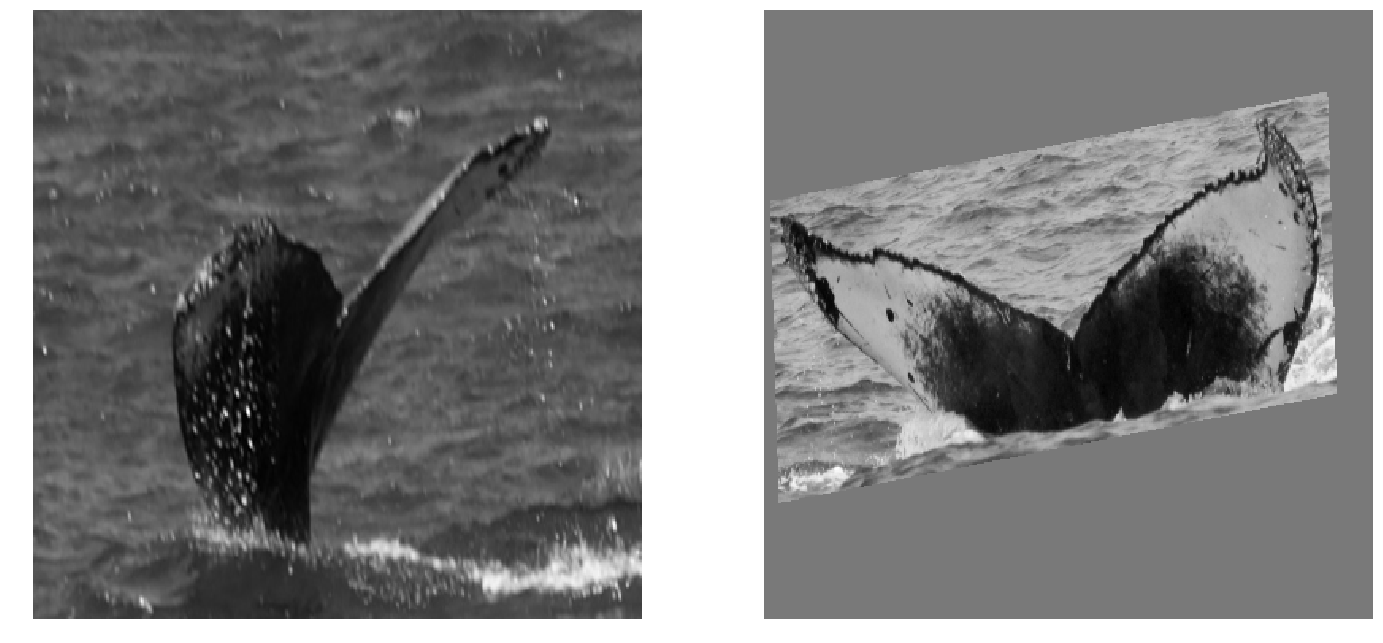

In [249]:
# First pair is for matching whale
imgs = [array_to_img(a[0]), array_to_img(b[0])]
show_whale(imgs, per_row=2)

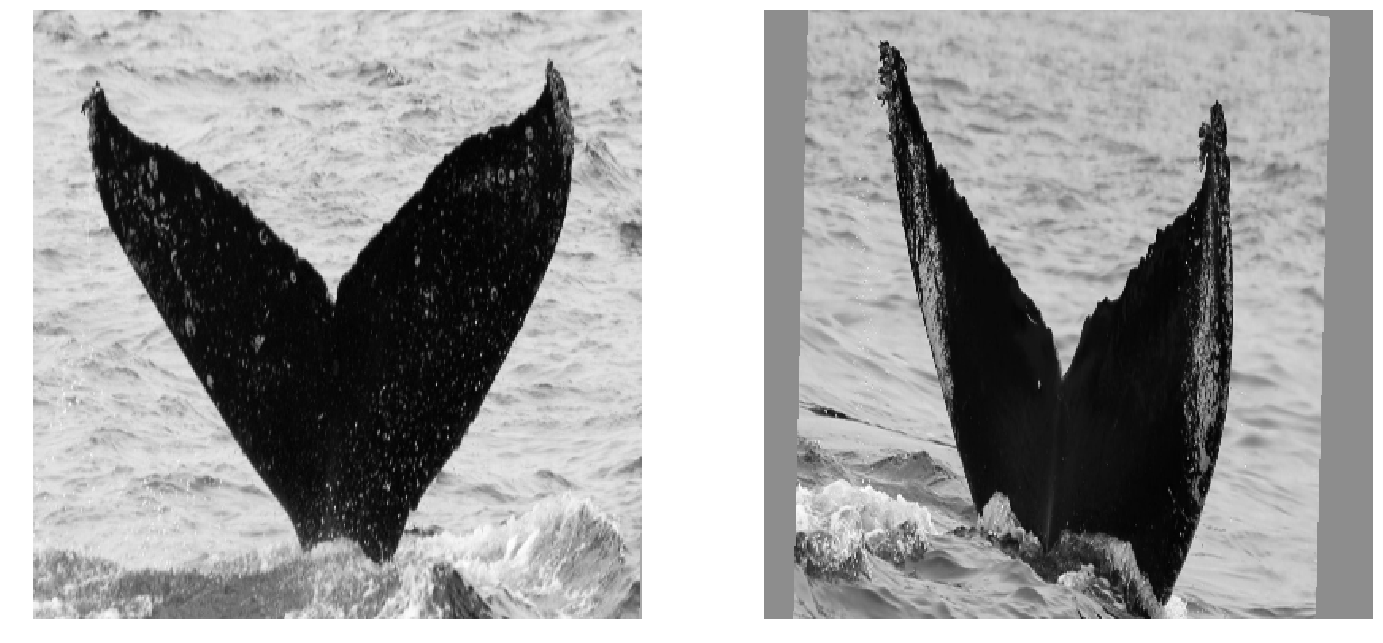

In [250]:
# Second pair is for different whales
imgs = [array_to_img(a[1]), array_to_img(b[1])]
show_whale(imgs, per_row=2)

## Training procedure

In [261]:
# A Keras generator to evaluate only the branch model
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data = data 
        self.batch_size = batch_size
        self.verbose = verbose
        if self.verbose > 0:
            self.progress = tqdm_notebook(total=len(self), desc='Features')
    
    def __getitem__(self, index):
        start = self.batch_size * index
        size = min(len(self.data) - start, self.batch_size)
        a = np.zeros((size, ) + img_shape, dtype=K.floatx())
        for i in range(size):
            a[i, :, :, :] = read_for_validation(self.data[start + 1])
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self):
                self.progress.close()
        return a
    
    def __len__(self):
        return (len(self.data) + self.batch_size - 1) // self.batch_size

In [252]:
# A Keras generator to evaluate on the head model on features features already pre-computed.
# It computes only the upper triangular matrix of the cost matrix if y is None
class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.verbose = verbose
        if y is None:
            self.y = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0], 1)
        else:
            self.iy, self.ix = np.indices((y.shape[0], x.shape[0]))
            self.ix = self.ix.reshape((self.ix.size, ))
            self.iy = self.iy.reshape((self.iy.size, ))
        self.subbatch = (len(self.x) + self.batch_size - 1) // self.batch_size
        if self.verbose > 0:
            self.progress = tqdm_notebook(total=len(self), desc='Scores')
            
    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, len(self.ix))
        a = self.y[self.iy[start: end], :]
        b = self.x[self.ix[start: end], :]
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self):
                self.progress.close()
        return [a, b]
    
    def __len__(self):
        return (len(self.ix) + self.batch_size - 1) // self.batch_size

In [255]:
!pip install keras_tqdm

In [267]:
from keras_tqdm import TQDMNotebookCallback

def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))
    
def get_lr(model):
    return K.get_value(model.optimizer.lr)

def score_reshape(score, x, y=None):
    """
    Transformed the packed matrix 'score' into a square matrix.
    """
    if y is None:
        # When y is None, score is a packed upper triangular matrix.
        # Uppack, and transpose to form the symmetrical lower triangular matrix.
        m = np.zeros((x.shape[0], x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0], 1)] = score.squeeze()
        m += m.transpose()
    else:
        m = np.zeros((y.shape[0], x.shape[0]), dtype=K.floatx())
        iy, ix = np.indices((y.shape[0], x.shape[0]))
        ix = ix.reshape((ix.size,))
        iy = ix.reshape((iy.size,))
        m[iy, ix] = score.squeeze()
    return m

def compute_score(verbose=1):
    """
    Compute the score matrix by scoring every pictures from the trianing set aginst every other picture O(n^2)
    """
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, \
                                              workers=6, verbose=0, steps=100)
    score = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, \
                                         workers=6, verbose=0, steps=100)
    score = score_reshape(score, features)
    return features, score

def make_steps(step, ampl):
    """
    Perform training epochs to perform
    """
    global w2ts, t2i, steps , features, score, histories
    
    # shuffle the training pictures
    random.shuffle(train)
    
    # Map whale id to the list of associated training picture hash value
    w2ts = {}
    for w, hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts:
                    w2ts[w] = []
                if h not in w2hs[w]:
                    w2ts[w].append(h)
    for w, ts in w2ts.items():
        w2ts[w] = np.array(ts)
    
    # Map training picture hash value to index in 'train' array
    t2i = {}
    for i, t in enumerate(train):
        t2i[t] = i
    
    # Compute the match score for each picture pair
    features, score = compute_score()
    
    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainingData(score + ampl * np.random.random_sample(size=score.shape), steps=step,
                    batch_size=32),
        initial_epoch = steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=0,
        callbacks=[TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}')]).history
    
    # Collect history data
    history['epochs'] = steps
    history['ms'] = np.mean(score)
    history['lr'] = get_lr(model)
    print(history['epochs'], history['lr'], history['ms'])
    histories.append(history)
    

In [258]:
model_name = 'siamese.model'
histories = []
steps = 0

In [268]:
# epoch -> 10
make_steps(10, 1000)
ampl = 100.0
for _ in range(10):
    print('noise ampl. = ', ampl)
    make_steps(5, ampl)
    ampl = max(1.0, 100 ** -0.1 * ampl)

# epoch -> 150
for _ in range(18):
    make_steps(5, 1.0)

# epoch -> 200
set_lr(model, 16e-5)
for _ in range(10):
    make_steps(5, 0.25)
    
# epoch -> 240
set_lr(mode, 4e-5)
for _ in range(8):
    make_steps(5, 0.25)

# epoch -> 250
set_lr(model, 1e-5)
for _ in range(2):
    make_steps(5, 0.25)
    
# epoch -> 300
weights = model.get_weights()
model, branch_model, head_model = build_model(64e-5, 0.0002)
model.set_weights(weights)
    
for _ in range(10): 
    make_steps(5, 1.0)

# epoch -> 350
set_lr(model, 16e-5)
for _ in range(10):
    make_steps(5, 0.5)

# epoch -> 390
set_lr(model, 4e-5)
for _ in range(8): make_steps(5, 0.25)
    
# epoch -> 400
set_lr(model, 1e-5)
for _ in range(2): make_steps(5, 0.25)
model.save('siamese.model')
    

HBox(children=(IntProgress(value=0, description='Features', max=213), HTML(value='')))

KeyboardInterrupt: 